In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from utils import save_fig_for_raport
from pandas.plotting import autocorrelation_plot
import pandas.plotting
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

/home/archie/code/Masteroppgave/venv-pycharm2/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
raw_data = pd.read_csv('../datasets/raw/market_insights_overview_all_2022_02_14.csv', parse_dates=["date"])

# Filter away early 2018 data as it seems to contain errors
raw_data =raw_data .loc[raw_data ['date'] > '2018-12-01']

In [3]:
categories = pd.read_csv("../datasets/raw/solr_categories_all_2022_02_14.csv")
# Join market_insight table with category names
category_names = categories[[ "internal_doc_id", "title"]]
category_id_to_names_map = dict(map(lambda x: (x["internal_doc_id"], x["title"]), category_names.to_dict("records")))
category_name_to_id_map = dict(map(lambda x: (x["title"], x["internal_doc_id"]), category_names.to_dict("records")))

In [4]:

data_grouped = raw_data.groupby(['cat_id', "date"], as_index=False).count()
data_grouped["date"] = pd.to_datetime(data_grouped["date"])
data_grouped["interest"] = data_grouped["hits"] + data_grouped["clicks"]

# Join with category names
data_grouped = pd.merge(data_grouped , category_names, how="left", left_on=["cat_id"], right_on=["internal_doc_id"])
data_grouped.rename(columns={"title": "cat_name"}, inplace=True)
data_grouped.drop(columns=["internal_doc_id"], inplace=True, axis=1)

data_chosen_categories = data_grouped[["interest", "date", "cat_id", "cat_name"]]
data = data_chosen_categories
data.head()

,interest,date,cat_id,cat_name
0,1858,2018-12-02,2,Bærbar PC
1,2064,2018-12-03,2,Bærbar PC
2,2024,2018-12-04,2,Bærbar PC
3,1940,2018-12-05,2,Bærbar PC
4,1860,2018-12-06,2,Bærbar PC


In [5]:
# Fill in all missing days
#data_grouped_filled_dates = data_chosen_categories.groupby(pd.Grouper(key="date", freq='D')).sum()

#data = data_grouped_filled_dates
#data.head()

In [6]:
# Pivot table by cat_id
data_by_cat_id = data.pivot(index=["date"], columns=["cat_id", "cat_name"])["interest"]

In [8]:
corr_categories = [2, 6, 9, 10, 11, 13, 20]

seasonal_categories_cat_name =["Vinterjakke",
"Vintersko",
"Langrennski",
"Skisko",
"Varmeovn",
"Snøfreser",
"Snøskuffe",]

seasonal_categories = list(map(lambda x: category_name_to_id_map[x], seasonal_categories_cat_name))
seasonal_categories

[12322, 11428, 11850, 11852, 273, 11036, 11213]

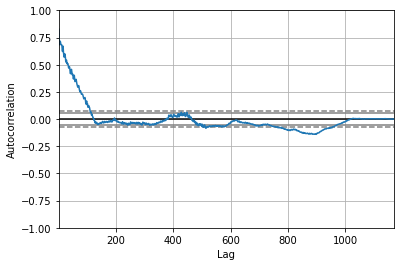

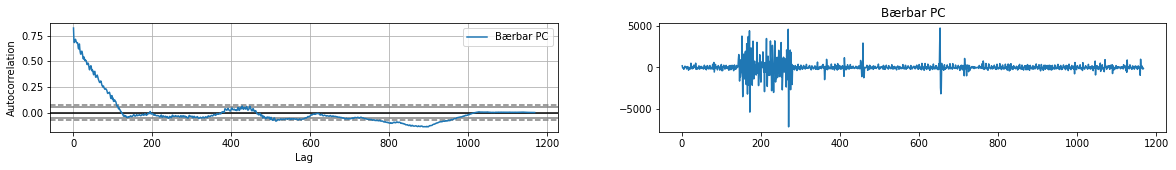

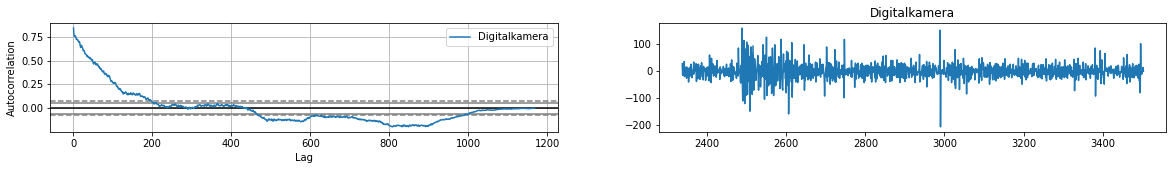

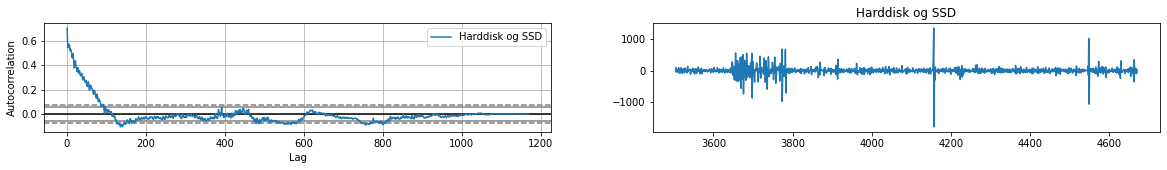

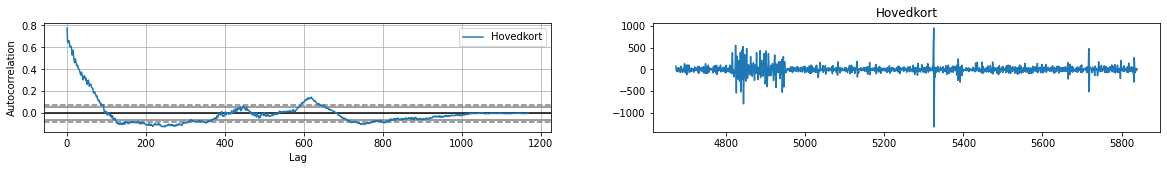

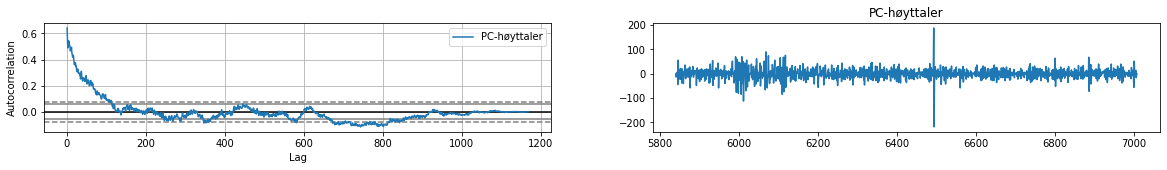

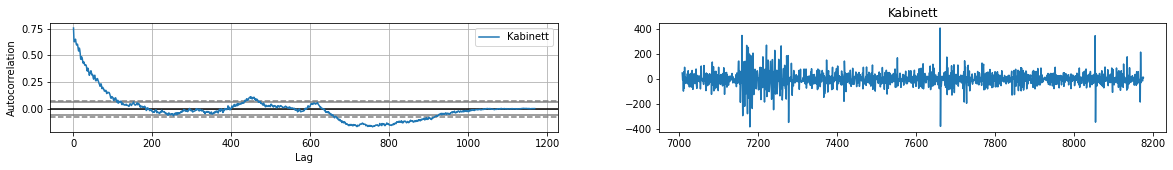

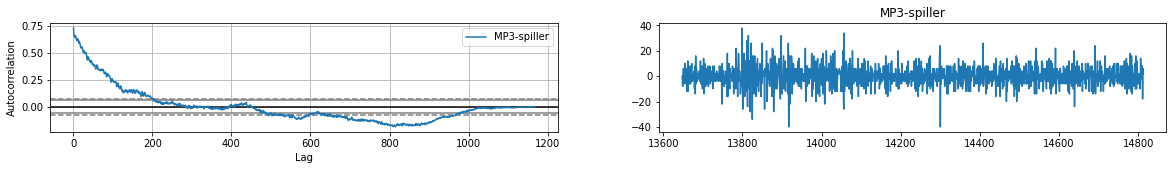

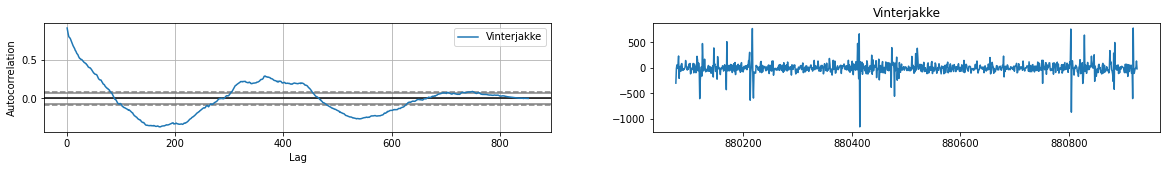

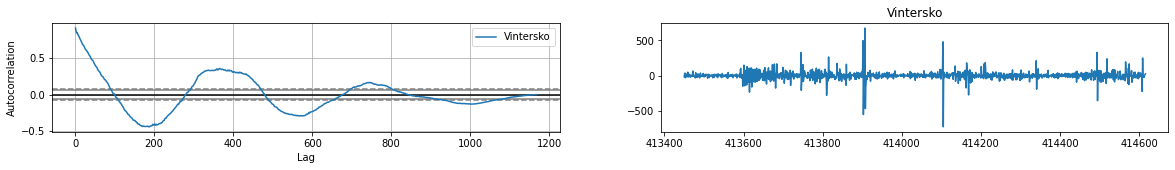

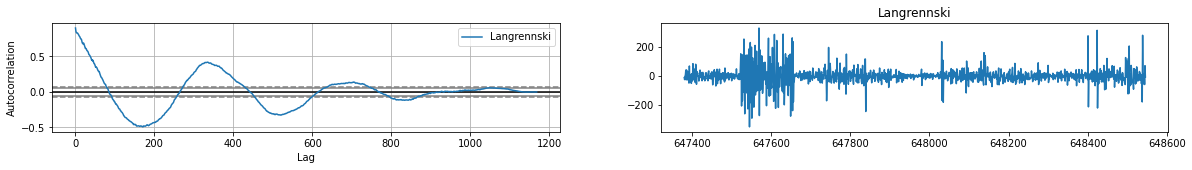

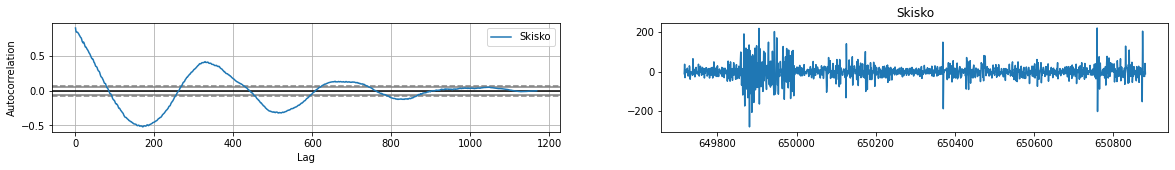

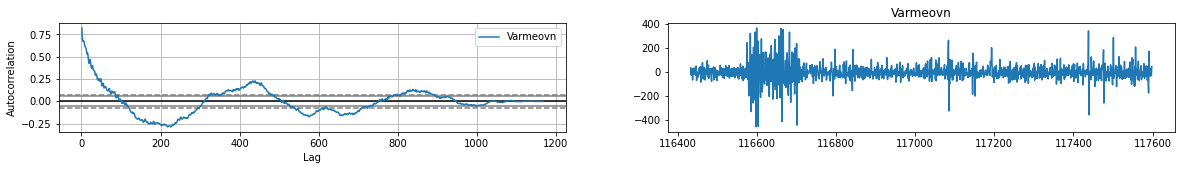

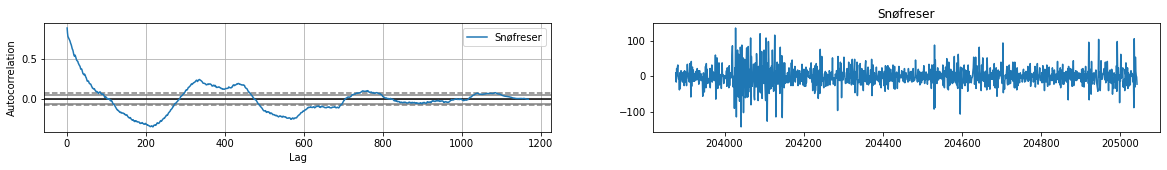

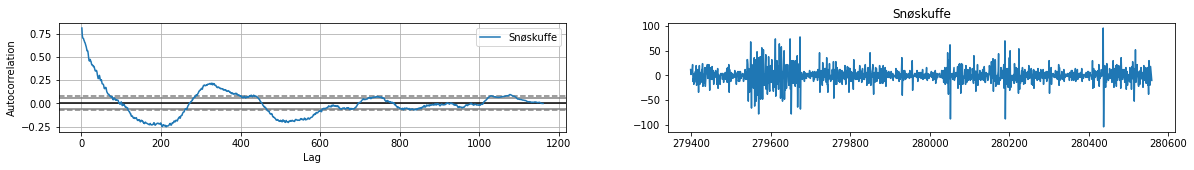

In [95]:
pandas.plotting.autocorrelation_plot(data[data["cat_id"] == 2]["interest"])
for cat in corr_categories + seasonal_categories:
  filtered = data[data["cat_id"] == cat]
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 2))
  ax = pandas.plotting.autocorrelation_plot(filtered["interest"], label=category_id_to_names_map[cat] if cat in category_id_to_names_map else cat, ax=axes[0])
  # Plot random walk. 
  walk_diff = filtered["interest"].diff()
  walk_diff.plot(title=category_id_to_names_map[cat] if cat in category_id_to_names_map else cat, label="Noisek", ax=axes[1])

## Dicky-Fuller test
"
If the found slope (β) is equal to 0, the series is a random walk. If the slope is significantly different from 0, we reject the null hypothesis that the series follows a random walk.
"

We look at the p-value, which is ~0.26. Since 0.05 is the significance threshold, we fail to reject the null hypothesis that drifty_walk is a random walk, i.e., it is a random walk.

1. If ADF statistics < critical calues => Reject the null hypothesis (it is stationary)
2. if ADF statistics > critical values => failed to reject the null hypothosis

In [126]:
def df_test(df):
  filtered = df
  dicky_fuller_test = adfuller(filtered, autolag='AIC')
  print(f"catregory: {cat}, {category_id_to_names_map[cat] if cat in category_id_to_names_map else cat}")
  print(
        f"p-value: {dicky_fuller_test[1]}\n",
        f"ADF Statistic: {dicky_fuller_test[0]}\n",
  )
  for key, value in dicky_fuller_test[4].items():
    print(f"Critical value for {key} at {dicky_fuller_test[1]}: {value}")
  print("\n")

In [127]:
for cat in seasonal_categories + corr_categories:
  filtered = data[data["cat_id"] == cat]["interest"]
  df_test(filtered)

catregory: 12322, Vinterjakke
p-value: 0.028428580395290327
 ADF Statistic: -3.075393588465251

Critical value for 1% at 0.028428580395290327: -3.4381032536542913
Critical value for 5% at 0.028428580395290327: -2.8649624121419746
Critical value for 10% at 0.028428580395290327: -2.5685923644574107


catregory: 11428, Vintersko
p-value: 0.05511193815870553
 ADF Statistic: -2.8226395041095116

Critical value for 1% at 0.05511193815870553: -3.43599497601695
Critical value for 5% at 0.05511193815870553: -2.8640326585367473
Critical value for 10% at 0.05511193815870553: -2.5680971485495068


catregory: 11850, Langrennski
p-value: 0.21194775062028193
 ADF Statistic: -2.1844223351943324

Critical value for 1% at 0.21194775062028193: -3.436064032324827
Critical value for 5% at 0.21194775062028193: -2.864063122757945
Critical value for 10% at 0.21194775062028193: -2.5681133731450605


catregory: 11852, Skisko
p-value: 0.13398394792846557
 ADF Statistic: -2.4280188011725192

Critical value for 1%

Result:
None of the P-values are below 0.05, which is required to reject the null hypothosis.
None of the time series are stationary.

## Decompose time series
We can decompose each series in into its trend, seasonality and residuals (rest).
Then we can use the dicky-fuller test on the residuals to check if the series is stationary.
If the p-value is < 0.05 it is stationary.
Results: The risiduals are mostly stationary

catregory: 2, Bærbar PC
p-value: 0.005727613269776858
 ADF Statistic: -3.6017524313445377

Critical value for 1% at 0.005727613269776858: -3.4387398917732193
Critical value for 5% at 0.005727613269776858: -2.8652430432199654
Critical value for 10% at 0.005727613269776858: -2.5687418568690683


catregory: 6, Digitalkamera
p-value: 0.0019343319692347938
 ADF Statistic: -3.9139807600306713

Critical value for 1% at 0.0019343319692347938: -3.438602251755426
Critical value for 5% at 0.0019343319692347938: -2.8651823762743245
Critical value for 10% at 0.0019343319692347938: -2.5687095387840673


catregory: 9, Harddisk og SSD
p-value: 0.001436231983633501
 ADF Statistic: -3.9951292115419674

Critical value for 1% at 0.001436231983633501: -3.4387184182983686
Critical value for 5% at 0.001436231983633501: -2.865233578638179
Critical value for 10% at 0.001436231983633501: -2.5687368149338816


catregory: 10, Hovedkort
p-value: 0.004170277670953436
 ADF Statistic: -3.695964414619292

Critical val

/tmp/ipykernel_3028/513456876.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(5, 5))


catregory: 11852, Skisko
p-value: 0.009044323343684303
 ADF Statistic: -3.461094658597566

Critical value for 1% at 0.009044323343684303: -3.438697054464251
Critical value for 5% at 0.009044323343684303: -2.8652241623148678
Critical value for 10% at 0.009044323343684303: -2.5687317987167284


catregory: 273, Varmeovn
p-value: 0.0012155827272785204
 ADF Statistic: -4.039861337680272

Critical value for 1% at 0.0012155827272785204: -3.4387398917732193
Critical value for 5% at 0.0012155827272785204: -2.8652430432199654
Critical value for 10% at 0.0012155827272785204: -2.5687418568690683


catregory: 11036, Snøfreser
p-value: 0.01084370876253874
 ADF Statistic: -3.4033941282640208

Critical value for 1% at 0.01084370876253874: -3.4387291412780177
Critical value for 5% at 0.01084370876253874: -2.8652383048736056
Critical value for 10% at 0.01084370876253874: -2.568739332674375


catregory: 11213, Snøskuffe
p-value: 0.014698019998749126
 ADF Statistic: -3.3040587546274214

Critical value for

<Figure size 360x360 with 0 Axes>

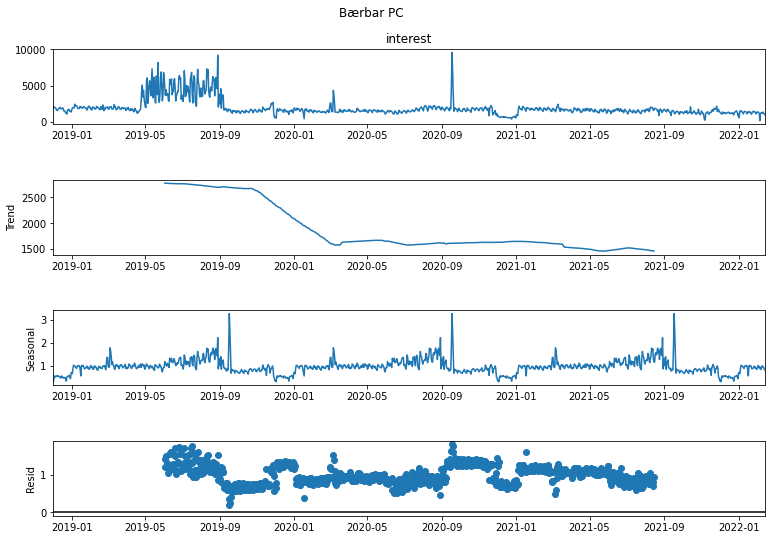

<Figure size 360x360 with 0 Axes>

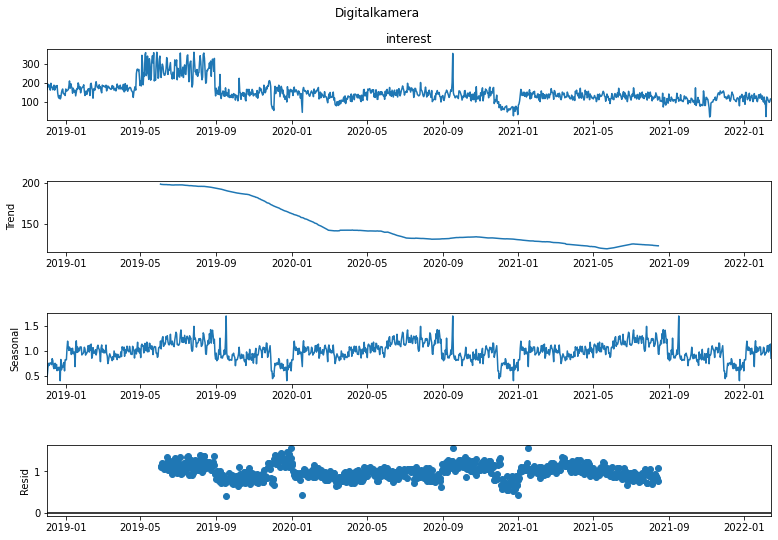

<Figure size 360x360 with 0 Axes>

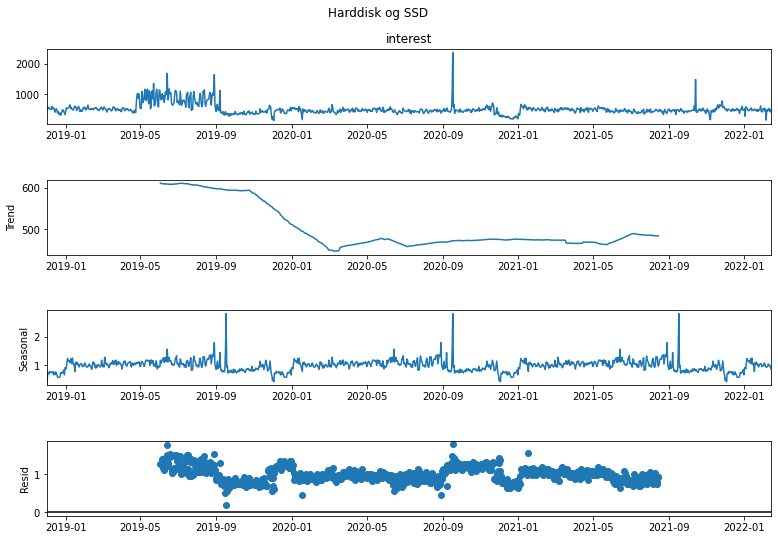

<Figure size 360x360 with 0 Axes>

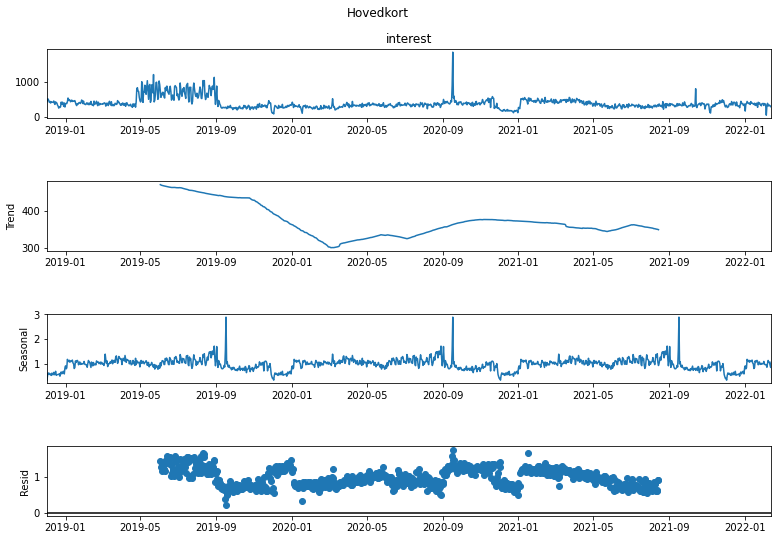

<Figure size 360x360 with 0 Axes>

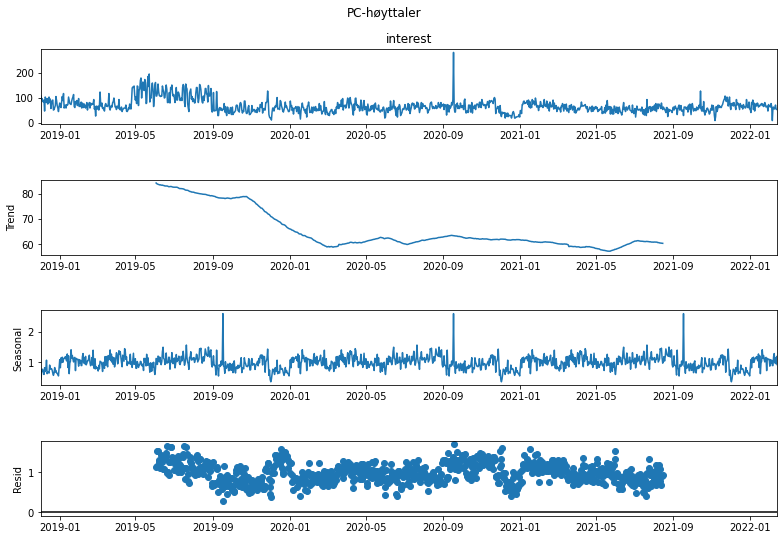

<Figure size 360x360 with 0 Axes>

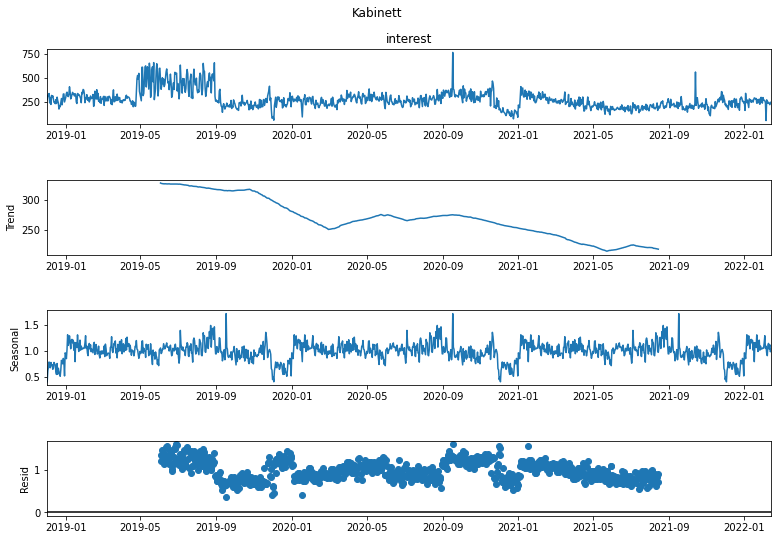

<Figure size 360x360 with 0 Axes>

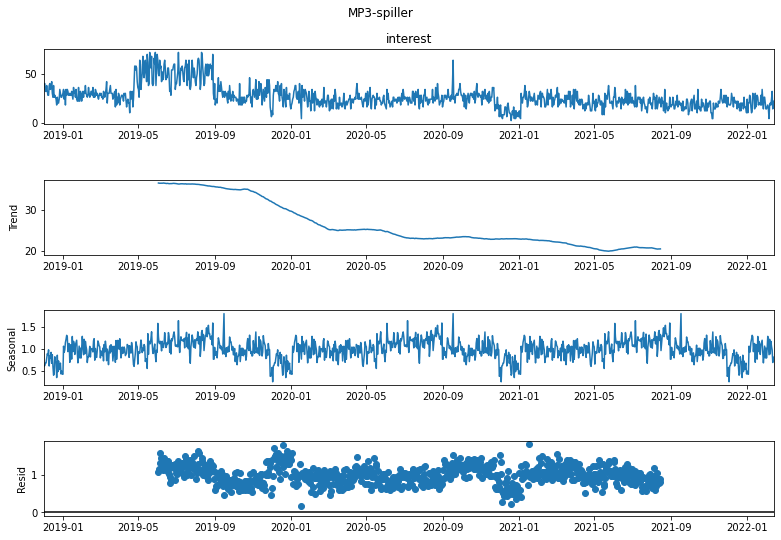

<Figure size 360x360 with 0 Axes>

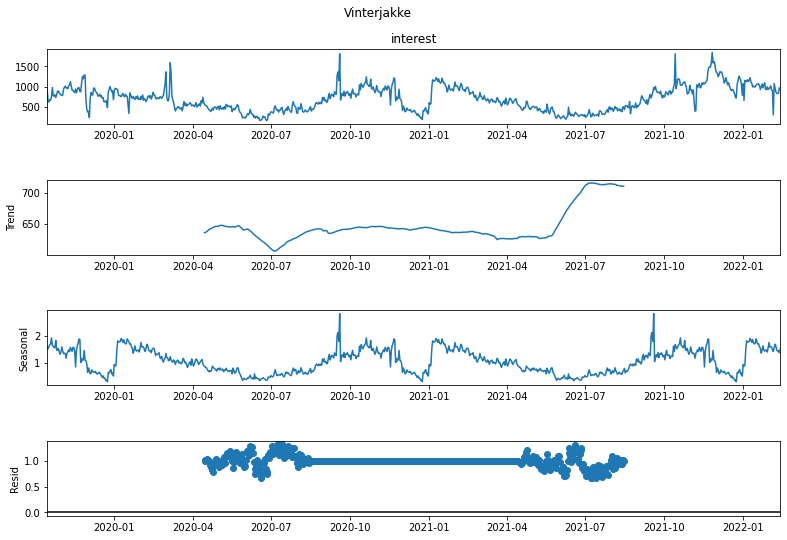

<Figure size 360x360 with 0 Axes>

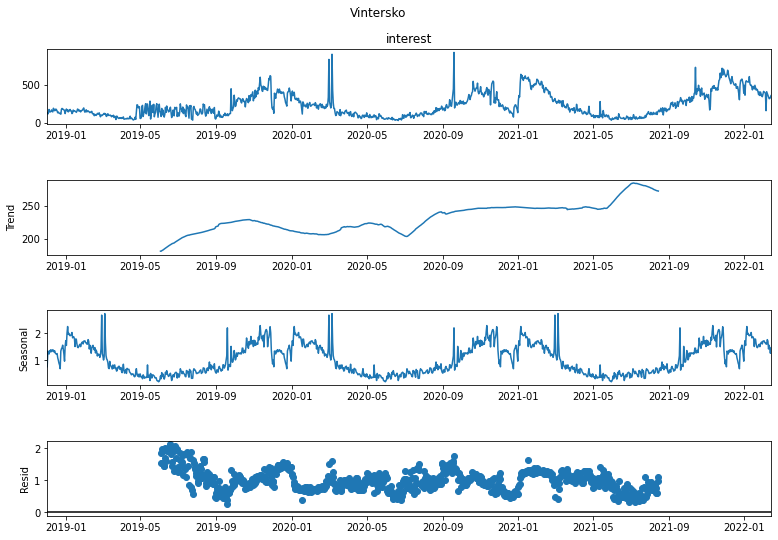

<Figure size 360x360 with 0 Axes>

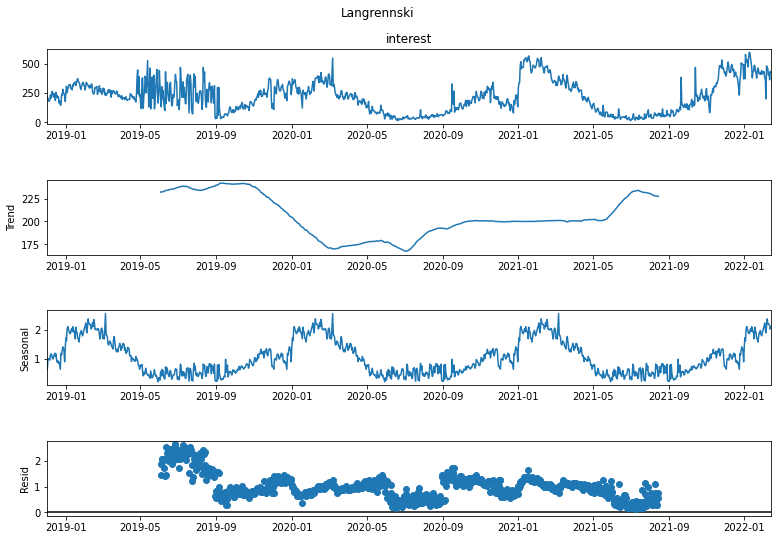

<Figure size 360x360 with 0 Axes>

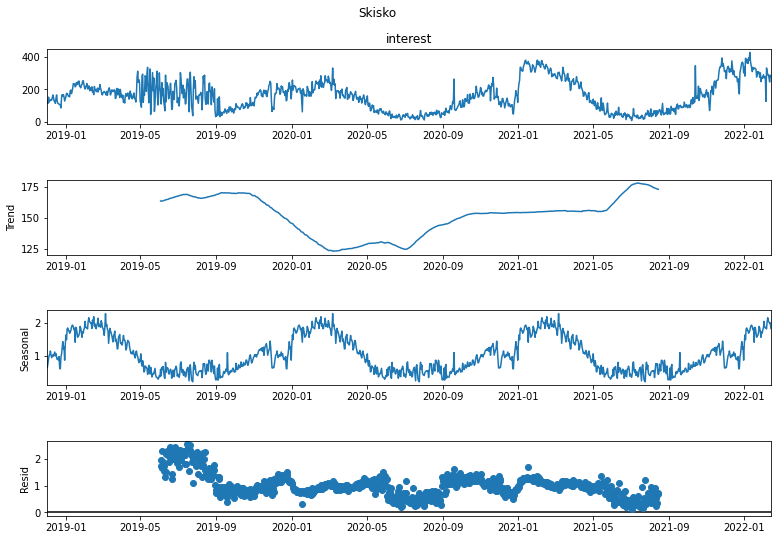

<Figure size 360x360 with 0 Axes>

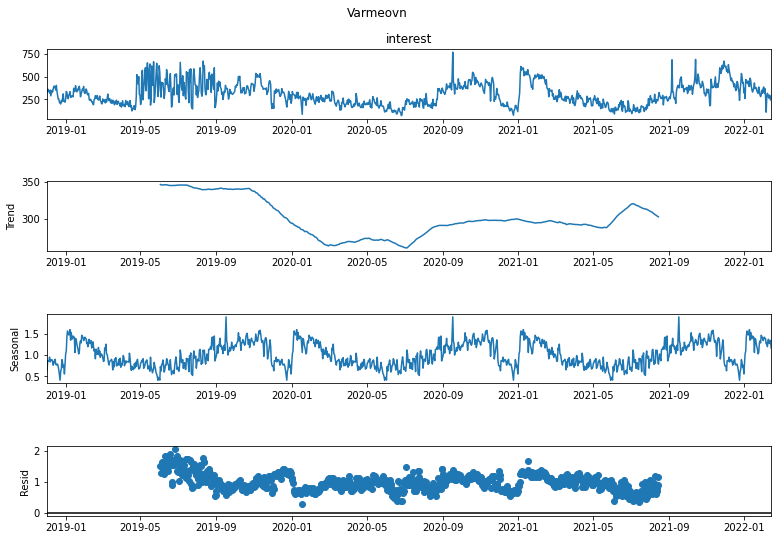

<Figure size 360x360 with 0 Axes>

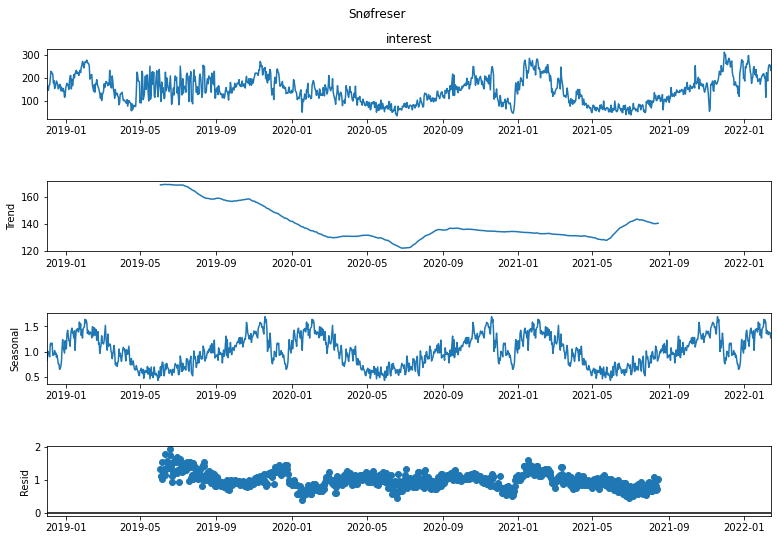

<Figure size 360x360 with 0 Axes>

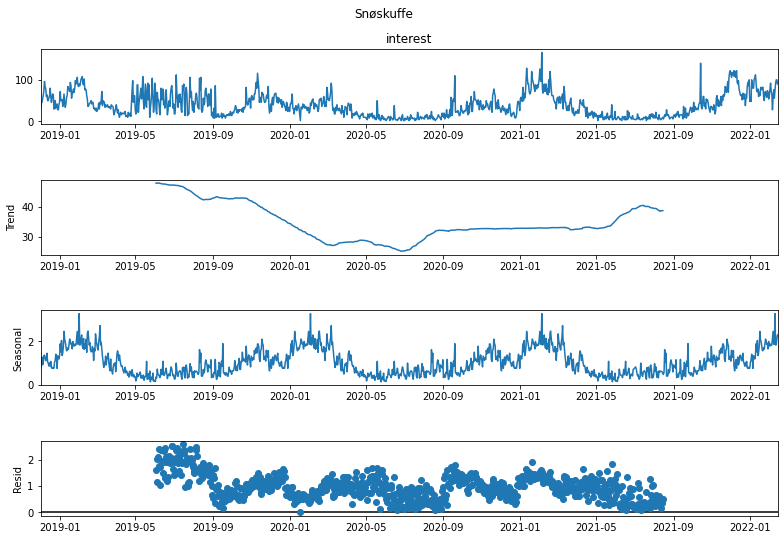

In [129]:
data_date_index = data.set_index("date", inplace=False)
for cat in corr_categories + seasonal_categories:
  filtered = data_date_index[data_date_index["cat_id"] == cat]["interest"]
  cat_name = category_id_to_names_map[cat] if cat in category_id_to_names_map else cat
  decompose = seasonal_decompose(filtered, model="multiplicative", period=365)
  fig = plt.figure(figsize=(5, 5))
  fig = decompose.plot()
  fig.set_size_inches(12, 8)
  fig.suptitle(cat_name)

  df_test(decompose.resid.dropna())